In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

***From this line to my next overstriking markdown, I try to do the basic cleaning and merging of the data. These only need to be ran once and will create another document called "OEWS_filtered.csv" in the root documents. Please remenber these codes should not be run necause the original document is too large to be uploaded here.***

In [3]:
#dfs = []  

#for year in range(2020, 2025):
#    filename = f"state_M{year}_dl.xlsx"
#    df = pd.read_excel(filename, engine="openpyxl")
#    df["year"] = year
#    dfs.append(df)
#    print(f"Loaded {filename}")
#    print(df.head(5))      
#    print(df.columns, "\n") 

#merged_df = pd.concat(dfs, ignore_index=True)

#print("Merged dataset created!")
#print("Shape:", merged_df.shape)
#print(merged_df.tail(5))

In [4]:
#merged_df.to_csv("oews_state_2020_2024.csv", index=False)

In [8]:
#keep = [
#    "year",
#    "PRIM_STATE", "AREA_TITLE",
#    "OCC_CODE", "OCC_TITLE", "O_GROUP",
#    "TOT_EMP", "A_MEAN", "A_MEDIAN", "H_MEAN", "H_MEDIAN",
#    "LOC_QUOTIENT", "PCT_TOTAL", "NAICS_TITLE"
#]
#keep = [c for c in keep if c in merged_df.columns]
#df = merged_df[keep].copy()
#df.to_csv("OEWS_filtered.csv", index=False,encoding="utf-8-sig")
#print(df.shape)
#print(df.columns.tolist())

In [9]:
#df.info()
#df.isna().sum().sort_values(ascending=False).head(10)

***Until now we have gain a basic understanding of the data, and we are going to read the newly created document "OEWS_filtered.csv" to start further data cleaning. From now on we can run the code.***

## Inference task 

This is how we read the content of "OEWS_filtered.csv" without open it.

In [9]:
df=pd.read_csv("OEWS_filtered.csv")

Another way of doing it is:

In [10]:
# with open("OEWS_filtered.csv","r") as f:
#     content=f.read()

or we can do it similarly:

In [11]:
# with open("OEWS_filtered.csv","r") as f:
#     for line in f:
#         row=line.stripe().split(",")

This line tend to drop the colume with no data filled.

In [12]:
df = df.drop(columns=["PCT_TOTAL"])

This two lines defines the numeric columns which initially I want to use in my analysis, and apply them into numeric forms by pandas.to_numeric.

In [13]:
numeric_cols = ["TOT_EMP","A_MEAN","A_MEDIAN","H_MEAN","H_MEDIAN","LOC_QUOTIENT"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

These lines tries to drop duplicate values in the subset combinations, drop rows without mean wage, and remove invalid zeros or suppressed cells.

In [14]:
df = df.drop_duplicates(subset=["year","PRIM_STATE","OCC_CODE"])
df = df.dropna(subset=["A_MEAN"])  
df = df[df["A_MEAN"] > 1000]  

The following code shows my calculation method of wage_growth.

In [15]:
df = df.sort_values(["OCC_CODE","PRIM_STATE","year"])
df["wage_growth"] = df.groupby(["OCC_CODE","PRIM_STATE"])["A_MEAN"].pct_change()

The following code shows my calculation method of employment_growth.

In [16]:
df["employment_growth"] = (df.groupby(["OCC_CODE", "PRIM_STATE"])["TOT_EMP"].pct_change(fill_method=None))

Then for the purpose of fitting the model better, use A_MEAN to get log_mean_wage, use TOT_EMP to get log_emp.

In [17]:
df["log_mean_wage"] = np.log(df["A_MEAN"])
df["log_emp"] = np.log(df["TOT_EMP"].where(df["TOT_EMP"] > 0))

Draw some plots to basically show the data, to tell if there exist obvious mistakes.

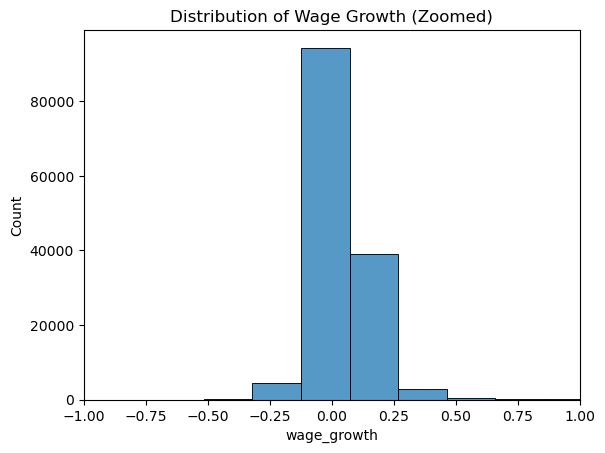

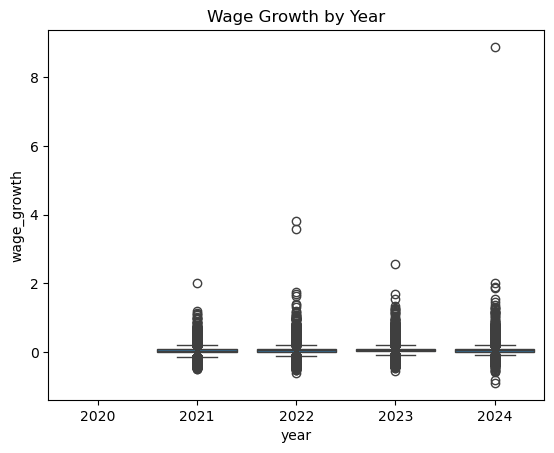

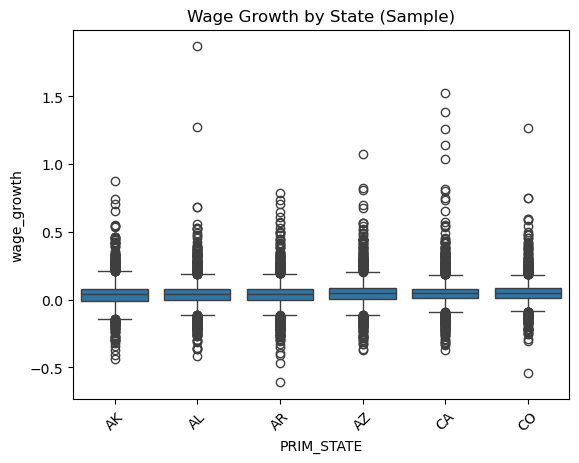

In [18]:
sns.histplot(df["wage_growth"].dropna(), bins=50)
plt.xlim(-1, 1)
plt.title("Distribution of Wage Growth (Zoomed)")
plt.show()

sns.boxplot(x="year", y="wage_growth", data=df)
plt.title("Wage Growth by Year")
plt.show()

sample_states = df["PRIM_STATE"].unique()[:6]
sns.boxplot(x="PRIM_STATE", y="wage_growth", data=df[df["PRIM_STATE"].isin(sample_states)])
plt.title("Wage Growth by State (Sample)")
plt.xticks(rotation=45)
plt.show()

Calculate the average wage growth by year.

In [19]:
df.groupby("year")["wage_growth"].mean()

year
2020         NaN
2021    0.027402
2022    0.052208
2023    0.058895
2024    0.045628
Name: wage_growth, dtype: float64

Rank occupation groups by wage growth.

In [20]:
df.groupby("O_GROUP")["wage_growth"].mean().sort_values(ascending=False)

O_GROUP
total       0.046827
detailed    0.046585
major       0.044947
Name: wage_growth, dtype: float64

Describe the TOT_EMP data. 

In [21]:
df["TOT_EMP"].describe()

count    1.773960e+05
mean     1.244867e+04
std      1.697998e+05
min      3.000000e+01
25%      2.300000e+02
50%      8.000000e+02
75%      3.190000e+03
max      1.805785e+07
Name: TOT_EMP, dtype: float64

Show all columns for later modeling.

In [22]:
print(df.columns)

Index(['year', 'PRIM_STATE', 'AREA_TITLE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP',
       'TOT_EMP', 'A_MEAN', 'A_MEDIAN', 'H_MEAN', 'H_MEDIAN', 'LOC_QUOTIENT',
       'NAICS_TITLE', 'wage_growth', 'employment_growth', 'log_mean_wage',
       'log_emp'],
      dtype='object')


List columns I want for my model and check that they're clean.

In [23]:
cols = ["log_emp", "LOC_QUOTIENT", "employment_growth", "log_mean_wage", "wage_growth"]
df_clean = (df.replace([np.inf, -np.inf], np.nan).dropna(subset=cols))

Drop the lines with inappropriate missing values.

In [24]:
X_vif = sm.add_constant(df[cols])
print(X_vif.isna().sum())         
print(np.isinf(X_vif).sum())  

const                    0
log_emp               5677
LOC_QUOTIENT          5677
employment_growth    47793
log_mean_wage            0
wage_growth          41527
dtype: int64
const                0
log_emp              0
LOC_QUOTIENT         0
employment_growth    0
log_mean_wage        0
wage_growth          0
dtype: int64


In [25]:
X_vif[np.isinf(X_vif).any(axis=1) | X_vif.isna().any(axis=1)]
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
X_vif = X_vif.dropna()
print(X_vif.isna().sum())         
print(np.isinf(X_vif).sum())  

const                0
log_emp              0
LOC_QUOTIENT         0
employment_growth    0
log_mean_wage        0
wage_growth          0
dtype: int64
const                0
log_emp              0
LOC_QUOTIENT         0
employment_growth    0
log_mean_wage        0
wage_growth          0
dtype: int64


Define the variables and results for my model. Fit the model and print the result.

In [26]:
X = sm.add_constant(df_clean[["log_emp","LOC_QUOTIENT","employment_growth","log_mean_wage"]])
y = df_clean["wage_growth"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            wage_growth   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     134.8
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          3.82e-115
Time:                        08:15:59   Log-Likelihood:             1.2455e+05
No. Observations:              135280   AIC:                        -2.491e+05
Df Residuals:                  135275   BIC:                        -2.491e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0778      0.00

Fit the model again and calculate the standard error and interval with heteroskedasticity assumption.

In [27]:
robust = model.get_robustcov_results(cov_type="HC3")
print(robust.summary())

                            OLS Regression Results                            
Dep. Variable:            wage_growth   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     58.38
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           2.52e-49
Time:                        08:16:02   Log-Likelihood:             1.2455e+05
No. Observations:              135280   AIC:                        -2.491e+05
Df Residuals:                  135275   BIC:                        -2.491e+05
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0778      0.00

Print to see the number of observations with no missing values.

In [28]:
print("Number of observations used:", len(df_clean))

Number of observations used: 135280


Re-check the data.

In [29]:
print(df_clean[["log_emp","LOC_QUOTIENT","employment_growth","log_mean_wage"]].describe())

             log_emp   LOC_QUOTIENT  employment_growth  log_mean_wage
count  135280.000000  135280.000000      135280.000000  135280.000000
mean        6.939774       1.170795           0.062742      10.987815
std         1.897406       1.572973           0.441370       0.457334
min         3.401197       0.010000          -0.959184       9.742732
25%         5.521461       0.660000          -0.118644      10.658670
50%         6.756932       0.940000           0.004202      10.939692
75%         8.131531       1.280000           0.146667      11.277836
max        16.709091     131.460000          35.800000      13.462073


Check the collinearity of my model's variables.

In [30]:
df[["log_emp","LOC_QUOTIENT","employment_growth","log_mean_wage"]].corr()

,log_emp,LOC_QUOTIENT,employment_growth,log_mean_wage
log_emp,1.000000,0.046722,0.021985,-0.043775
LOC_QUOTIENT,0.046722,1.000000,0.089112,-0.003952
employment_growth,0.021985,0.089112,1.000000,-0.003260
log_mean_wage,-0.043775,-0.003952,-0.003260,1.000000


The skewness of the original LOC_QUOTIENT data is: 26.43769886937673
Saved original LOC_QUOTIENT skew plot to loc_quotient_skew.png


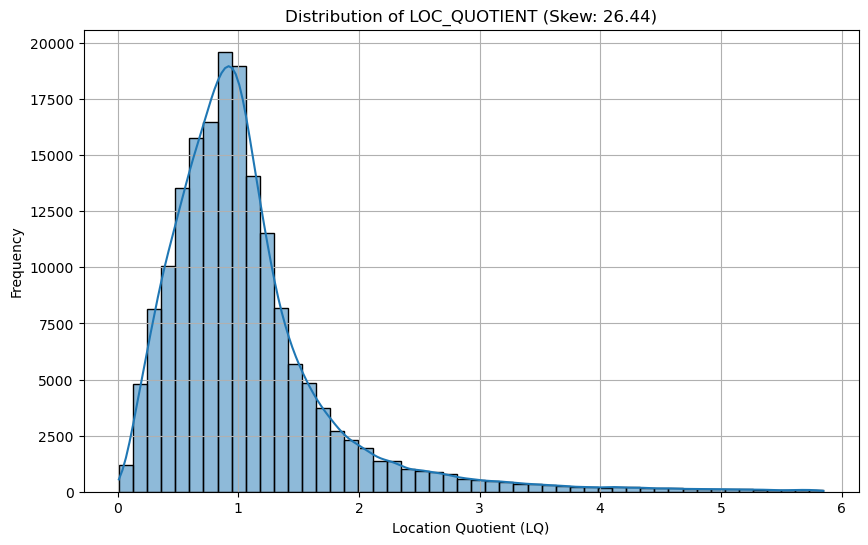

In [31]:
skew_value = df['LOC_QUOTIENT'].skew()
print(f"The skewness of the original LOC_QUOTIENT data is: {skew_value}")

plt.figure(figsize=(10, 6))
quantile_99 = df['LOC_QUOTIENT'].quantile(0.99)
sns.histplot(df['LOC_QUOTIENT'][df['LOC_QUOTIENT'] < quantile_99], kde=True, bins=50)
plt.title(f'Distribution of LOC_QUOTIENT (Skew: {skew_value:.2f})')
plt.xlabel('Location Quotient (LQ)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('loc_quotient_skew.png')
print("Saved original LOC_QUOTIENT skew plot to loc_quotient_skew.png")

To better normalize skewed data I used log-transforming of LOC_QUOTIENT.

In [32]:
df["log_LQ"] = np.log(df["LOC_QUOTIENT"]).where(df["LOC_QUOTIENT"] > 0)

In this case I use the transformed data of log_LQ to refit the model.

In [33]:
cols = ["log_emp", "log_LQ", "employment_growth", "log_mean_wage", "wage_growth"]
df_clean = (df
            .replace([np.inf, -np.inf], np.nan)
            .dropna(subset=cols))

X = sm.add_constant(df_clean[["log_emp", "log_LQ", "employment_growth", "log_mean_wage"]])
y = df_clean["wage_growth"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            wage_growth   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     143.8
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          7.08e-123
Time:                        08:16:27   Log-Likelihood:             1.2457e+05
No. Observations:              135280   AIC:                        -2.491e+05
Df Residuals:                  135275   BIC:                        -2.491e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0798      0.00

In [34]:
df[["log_emp","log_LQ","employment_growth","log_mean_wage"]].corr()

,log_emp,log_LQ,employment_growth,log_mean_wage
log_emp,1.000000,0.248919,0.021985,-0.043775
log_LQ,0.248919,1.000000,0.161156,-0.004548
employment_growth,0.021985,0.161156,1.000000,-0.003260
log_mean_wage,-0.043775,-0.004548,-0.003260,1.000000


Backward elimination.

In [35]:
X = sm.add_constant(df_clean[["log_emp", "employment_growth", "log_mean_wage"]])
y = df_clean["wage_growth"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            wage_growth   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     179.5
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          3.60e-116
Time:                        08:16:33   Log-Likelihood:             1.2455e+05
No. Observations:              135280   AIC:                        -2.491e+05
Df Residuals:                  135276   BIC:                        -2.491e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0780      0.00

Check the colinearity between the two variables.

In [36]:
df[["log_emp","log_LQ"]].corr()

,log_emp,log_LQ
log_emp,1.000000,0.248919
log_LQ,0.248919,1.000000


Create an interaction term to check whether that employment's effect on wages depends on the level of specialization.

In [37]:
df["log_emp_LQ"] = df["log_emp"] * df["log_LQ"]
X = sm.add_constant(df[["log_emp","log_LQ","log_emp_LQ",
                              "employment_growth","log_mean_wage"]])
model = sm.OLS(df["wage_growth"], X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            wage_growth   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     122.2
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          1.86e-129
Time:                        08:16:38   Log-Likelihood:             1.2459e+05
No. Observations:              135280   AIC:                        -2.492e+05
Df Residuals:                  135274   BIC:                        -2.491e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0815      0.00

My significant interaction term proves that employment's effect on wages depends on the level of specialization.

In [38]:
print(df.columns)

Index(['year', 'PRIM_STATE', 'AREA_TITLE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP',
       'TOT_EMP', 'A_MEAN', 'A_MEDIAN', 'H_MEAN', 'H_MEDIAN', 'LOC_QUOTIENT',
       'NAICS_TITLE', 'wage_growth', 'employment_growth', 'log_mean_wage',
       'log_emp', 'log_LQ', 'log_emp_LQ'],
      dtype='object')


As the R square is too small, which indicates the variables are not good at explaining the short-term, one-year changes in wages, I change my target variable (response) to be wage_growth_2yr.

In [39]:
df["wage_growth_2yr"] = df.groupby(["OCC_CODE","PRIM_STATE"])["A_MEAN"].pct_change(periods=2)

I re-clean the data for the model by this new target variable.

In [40]:
df_model1 = df[[
    "wage_growth_2yr",
    "log_emp", 
    "log_LQ", 
    "log_emp_LQ",
    "employment_growth", 
    "log_mean_wage"
]].copy()

df_model1 = df_model1.dropna(subset=["wage_growth_2yr"])

I confirms the response and variables for the model.

In [41]:
y = df_model1["wage_growth_2yr"]

X = df_model1[[
    "log_emp", 
    "log_LQ", 
    "log_emp_LQ",
    "employment_growth", 
    "log_mean_wage"
]]

I re-clean the data for the model by its variables, only keep the line that are not nan.

In [42]:
X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1) & y.notna()

X_clean = X[mask]
y_clean = y[mask]

I refit the model. Somehow the R-square becomes even smaller.

In [43]:
X_ols = sm.add_constant(X_clean)
model = sm.OLS(y_clean, X_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        wage_growth_2yr   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     44.91
Date:                Mon, 24 Nov 2025   Prob (F-statistic):           1.79e-46
Time:                        08:16:51   Log-Likelihood:                 64432.
No. Observations:               99298   AIC:                        -1.289e+05
Df Residuals:                   99292   BIC:                        -1.288e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0013      0.01

I redefined the needed columns for my next model.

In [44]:
feature_cols = [
    "log_emp", 
    "log_LQ", 
    "log_emp_LQ",
    "employment_growth", 
    "log_mean_wage"
]
fe_cols = ["year", "PRIM_STATE", "O_GROUP"]
target_col = "wage_growth_2yr"

In [45]:
df['year'] = df['year'].astype(str)

I decide to use fixed effects in my model, so I create dummy variables for it.

In [46]:
print("Creating dummy variables for fixed effects...")
df_model_fe = pd.get_dummies(
    df[feature_cols + fe_cols + [target_col]], 
    columns=fe_cols, 
    drop_first=True)
df_model_fe.head(5)

Creating dummy variables for fixed effects...


,log_emp,log_LQ,log_emp_LQ,employment_growth,log_mean_wage,wage_growth_2yr,year_2021,year_2022,year_2023,year_2024,...,PRIM_STATE_UT,PRIM_STATE_VA,PRIM_STATE_VI,PRIM_STATE_VT,PRIM_STATE_WA,PRIM_STATE_WI,PRIM_STATE_WV,PRIM_STATE_WY,O_GROUP_major,O_GROUP_total
731,12.599128,0.0,0.0,NaN,11.031011,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
36822,12.597709,0.0,0.0,-0.001417,11.058480,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
74401,12.631700,0.0,0.0,0.034575,11.099378,0.070758,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
111972,12.649508,0.0,0.0,0.017967,11.154535,0.100819,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
149646,12.679321,0.0,0.0,0.030262,11.195609,0.101013,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


I drop the rows that in my dummy variables there exist absent values.

In [47]:
df_model_fe = df_model_fe.replace([np.inf, -np.inf], np.nan).dropna()

I defined my response and variables for the model.

In [48]:
y = df_model_fe[target_col]
X = df_model_fe.drop(columns=[target_col])

In [49]:
print("Forcing X and y to numeric type...")
try:
    X = X.astype(float)
    y = y.astype(float)
    print("Data conversion successful.")
except ValueError as e:
    print(f"Error converting data to float: {e}")
    print("Finding problematic columns...")
    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            print(f"Column '{col}' is NOT numeric. It has dtype: {X[col].dtype}")

Forcing X and y to numeric type...
Data conversion successful.


I fit the model. Find myself a better R square, but many dummy variable, I think the model could be more efficient than this.

In [50]:
print("All columns are numeric. Fitting model...")
X_ols = sm.add_constant(X)
model_fe = sm.OLS(y, X_ols).fit()

print("\n--- OLS Regression Results with Fixed Effects ---")
print(model_fe.summary())

All columns are numeric. Fitting model...

--- OLS Regression Results with Fixed Effects ---
                            OLS Regression Results                            
Dep. Variable:        wage_growth_2yr   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     34.69
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        08:17:05   Log-Likelihood:                 65385.
No. Observations:               99298   AIC:                        -1.306e+05
Df Residuals:                   99235   BIC:                        -1.300e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

***Here I reload my data. And I choose panelOLS model, using the demeaned data to fit it.***

These steps are just the repetitions of what is above.

In [51]:
df = pd.read_csv("OEWS_filtered.csv")
df = df.drop(columns=["PCT_TOTAL"])
numeric_cols = ["TOT_EMP","A_MEAN","A_MEDIAN","H_MEAN","H_MEDIAN","LOC_QUOTIENT"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [52]:
df = df.drop_duplicates(subset=["year","PRIM_STATE","OCC_CODE"])
df = df.dropna(subset=["A_MEAN"])
df = df[df["A_MEAN"] > 1000]
df = df.sort_values(["OCC_CODE","PRIM_STATE","year"])

In [53]:
df["employment_growth"] = df.groupby(["OCC_CODE", "PRIM_STATE"])["TOT_EMP"].pct_change(fill_method=None)
df["log_mean_wage"] = np.log(df["A_MEAN"])
df["log_emp"] = np.log(df["TOT_EMP"].where(df["TOT_EMP"] > 0))
df["log_LQ"] = np.log(df["LOC_QUOTIENT"].where(df["LOC_QUOTIENT"] > 0))
df["log_emp_LQ"] = df["log_emp"] * df["log_LQ"]
df["wage_growth_2yr"] = df.groupby(["OCC_CODE","PRIM_STATE"])["A_MEAN"].pct_change(periods=2, fill_method=None)

In [54]:
df['year'] = pd.to_numeric(df['year'])

In [55]:
feature_cols = [
    "log_emp", 
    "log_LQ", 
    "log_emp_LQ",
    "employment_growth", 
    "log_mean_wage"
]
target_col = "wage_growth_2yr"

In [56]:
df_panel = df.dropna(subset=feature_cols + [target_col] + ["OCC_CODE", "PRIM_STATE", "year"])
df_panel = df_panel.replace([np.inf, -np.inf], np.nan).dropna()

In [57]:
df_panel["state_occ"] = df_panel["PRIM_STATE"] + "_" + df_panel["OCC_CODE"]

I modulate the structure of the data, to suit the needs of the panelOLS model.

In [58]:
df_panel = df_panel.set_index(["state_occ", "year"])

I fit the model.

In [59]:
y = df_panel[target_col]
X = df_panel[feature_cols]
X = sm.add_constant(X)

In [70]:
print("Running PanelOLS...")
model_panel = PanelOLS(
    y, 
    X, 
    entity_effects=True,  
    time_effects=True     
)
results_panel = model_panel.fit()

Running PanelOLS...


Here is my result, from this result I believe my previous models are biased and probably its because the result only considers the difference between variations but didn't consider within-group variations like structural differences in entity and time.

In [71]:
print(results_panel)

                          PanelOLS Estimation Summary                           
Dep. Variable:        wage_growth_2yr   R-squared:                        0.5593
Estimator:                   PanelOLS   R-squared (Between):             -37.531
No. Observations:               91616   R-squared (Within):               0.3376
Date:                Mon, Nov 24 2025   R-squared (Overall):             -23.992
Time:                        08:18:48   Log-likelihood                 1.328e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.474e+04
Entities:                       33529   P-value                           0.0000
Avg Obs:                       2.7324   Distribution:                 F(5,58080)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):          1.474e+04
                            